# Tutorial

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import cytokine_dict as cy

import warnings
from tqdm import TqdmWarning
import tqdm
warnings.simplefilter("ignore", TqdmWarning)

/home/icb/jenni.liu/miniconda3/envs/random_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# The Human Cytokine Dictionary

The Human Cytokine Dictionary (hcd) can be accessed through this module. Your query data should be a transcriptomic data object in AnnData's .h5ad format with gene symbols in .var axis and metadata describing immune celltypes and experimental conditions of samples. Using the Human Cytokine Dictionary as reference, you can "look up" cytokine responses of the disease states in your own dataset.

# 1. Load input data

The two main input files for this tool are:
1. the Human Cytokine Dictionary 
2. your transcriptome data object

Explore their metadata annotation for cell types and disease condition.

In [5]:
#### Load the human cytokine dictionary

df_hcd_all = cy.load_cytokine_dict_data()

print(f"All celltypes in dictionary:\n  {df_hcd_all.celltype.unique()}")
print("\n")
print(f"All cytokines in dictionary:\n  {df_hcd_all.cytokine.unique()}")

All celltypes in dictionary:
  ['Intermediate_B_cell' 'NKT' 'CD8_Memory_T_cell' 'NK_CD56low' 'CD16_Mono'
 'NK_CD56hi' 'CD8_Naive_T_cell' 'pDC' 'ILC' 'MAIT' 'Naive_B_cell'
 'CD4_Naive_T_cell' 'Treg' 'Plasmablast' 'Granulocyte' 'B' 'CD4' 'HSPC'
 'CD8' 'CD14_Mono' 'cDC' 'CD4_Memory_T_cell' 'NK' 'Mono']


All cytokines in dictionary:
  ['4-1BBL' 'ADSF' 'APRIL' 'BAFF' 'C3a' 'C5a' 'CD27L' 'CD30L' 'CD40L' 'CT-1'
 'Decorin' 'EGF' 'EPO' 'FGF-beta' 'FLT3L' 'FasL' 'G-CSF' 'GDNF' 'GITRL'
 'GM-CSF' 'HGF' 'IFN-alpha1' 'IFN-beta' 'IFN-epsilon' 'IFN-gamma'
 'IFN-lambda1' 'IFN-lambda2' 'IFN-lambda3' 'IFN-omega' 'IGF-1'
 'IL-1-alpha' 'IL-1-beta' 'IL-10' 'IL-11' 'IL-12' 'IL-13' 'IL-15' 'IL-16'
 'IL-17A' 'IL-17B' 'IL-17C' 'IL-17D' 'IL-17E' 'IL-17F' 'IL-18' 'IL-19'
 'IL-1Ra' 'IL-2' 'IL-20' 'IL-21' 'IL-22' 'IL-23' 'IL-24' 'IL-26' 'IL-27'
 'IL-3' 'IL-31' 'IL-32-beta' 'IL-33' 'IL-34' 'IL-35' 'IL-36-alpha'
 'IL-36Ra' 'IL-4' 'IL-5' 'IL-6' 'IL-7' 'IL-8' 'IL-9' 'LIF' 'LIGHT'
 'LT-alpha1-beta2' 'LT-alpha2-beta1' '

In [6]:
#### Load the query adata object

adata = sc.read_h5ad("lupus_norm_log1p.h5ad")
adata

AnnData object with n_obs × n_vars = 1263676 × 30933
    obs: 'library_uuid', 'cell_type_ontology_term_id', 'author_cell_type', 'cell_state', 'sample_uuid', 'development_stage_ontology_term_id', 'disease_state', 'suspension_uuid', 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'disease_ontology_term_id', 'sex_ontology_term_id', 'Processing_Cohort', 'ct_cov', 'ind_cov', 'cell_type', 'disease', 'sex', 'self_reported_ethnicity', 'development_stage'
    var: 'mean_expr_raw', 'frac_expr_cells', 'mean_expr_log1p'
    uns: 'cell_type_colors', 'log1p'
    obsm: 'X_umap'

In [7]:
# Enrichment analysis needs two main information from query adata: cell types and disease conditions.
# They have to be chosen manually, because annotation of objects differs. 

print(f"All celltypes in query data:\n  {sorted(adata.obs.cell_type.unique())}\n")
print(f"All experimental states (contrasts/conditions) in query data:\n  {sorted(adata.obs.disease_state.unique())}\n")

All celltypes in query data:
  ['B cell', 'CD4-positive, alpha-beta T cell', 'CD8-positive, alpha-beta T cell', 'classical monocyte', 'conventional dendritic cell', 'lymphocyte', 'natural killer cell', 'non-classical monocyte', 'plasmablast', 'plasmacytoid dendritic cell', 'progenitor cell']

All experimental states (contrasts/conditions) in query data:
  ['flare', 'managed', 'na', 'treated']



In [8]:
#### Optional for easy workflow:
# Enter celltype column name and condition column name

your_celltype_colname = "cell_type"
your_contrast_colname = "disease_state"

# Check data size (Are the conditions you want to contrast of comparable size?)

adata.obs[your_contrast_colname].value_counts()

disease_state
managed    696626
na         486418
flare       55120
treated     25512
Name: count, dtype: int64

# 2. Process and prepare input data parameters

1. Convert ENSG to gene symbols if necessary
2. Because there is no standard nomenclature for cell types, we have to manually create **"celltype_combos"**, the data container that matches the cell types of your query data to the cell types of the hcd.
3. Choose the experimental conditions of interest (**"contrasts"**)

In [9]:
#### query adata object needs to have gene symbols as adata.var.index. The Lupus data object didin't
import mygene

mg = mygene.MyGeneInfo()

results = mg.querymany(
    adata.var_names.tolist(),
    scopes='ensembl.gene',
    fields='symbol',
    species='human'
)

df = pd.DataFrame(results)

# Create mapping dict (fallback to Ensembl ID when symbol missing)
ensembl_to_symbol = df.set_index('query')['symbol'].fillna(df['query']).to_dict()

adata.var['gene_symbol'] = adata.var_names.map(ensembl_to_symbol)
adata.var_names_make_unique()

# 1. Keep only rows with a gene symbol
keep_idx = ~adata.var['gene_symbol'].isna()
adata = adata[:, keep_idx].copy()

# 2. Identify duplicate gene symbols
dup_idx = adata.var['gene_symbol'].duplicated(keep='first')

# 3. Keep only the first occurrence of each gene symbol
adata = adata[:, ~dup_idx].copy()

# 4. Set gene_symbol as the new var index
adata.var_names = adata.var['gene_symbol']


querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-21000...done.
querying 21001-22000...done.
querying 22001-23000...done.
querying 23001-24000...done.
querying 24001-25000...done.
querying 25001-26000...done.
querying 26001-27000...done.
querying 27001-28000...done.
querying 28001-29000...done.
querying 29001-30000...done.
querying 30001-30933...done.
Finished.
19 input query terms found dup hits:
	[('ENSG00000268674', 3), ('ENSG00000228044', 2), ('ENSG00000226506', 2), ('

In [10]:
#### Create celltype_combos. An input parameter for the enrichment analysis.

adata_celltypes = ['B cell', 'CD8-positive, alpha-beta T cell', 'classical monocyte']
hcd_celltypes = ['B', 'CD8', "CD14_Mono"]

celltype_combos = cy.create_celltype_combos(adata_celltypes, hcd_celltypes)
celltype_combos

(('B cell', 'B'),
 ('CD8-positive, alpha-beta T cell', 'CD8'),
 ('classical monocyte', 'CD14_Mono'))

In [11]:
#### Define conditions of interest:

contrasts = [("flare", "na") , ("flare", "managed")]

# 3. Run enrichment analysis

The main analysis is done by run_enrichment_test(), which computes enrichment scores of all query celltypes and conditions. 

1. To make the analysis more robust, different threholds are used that give us confidence in the outcome. Additionally, in the main example, enrichment of several cell types and conditions are computed in one run (I).
2. Alternatively, you can compute enrichment without extra robustness (II)
3. or only for a single cell type and condition (III).

In [12]:
#### (I) Main example: Robust analysis on several cell type and conditions

all_enrichment_results = []
for celltype_combo_k, celltype_combo in enumerate(celltype_combos):

    shared_kwargs = {
        "threshold_pval": 0.05,
        "direction": "upregulated",
        "min_size": 8,
        "max_size": 1_000,
        "permutation_num": 20_000,
        "verbose": True,
        "df_hcd_all": df_hcd_all,
        "adata": adata
    }

    for threshold_lfc in [0.8, 1]:
        shared_kwargs["threshold_lfc"] = threshold_lfc
        
        for threshold_expression in [0.05]:
            shared_kwargs["threshold_expression"] = threshold_expression
            
            results = cy.run_enrichment_test(
                celltype=celltype_combo,
                contrast_column=your_contrast_colname,
                celltype_column=your_celltype_colname,
                contrasts=contrasts,
                **shared_kwargs,
            )
            
            all_enrichment_results.append(results)

all_enrichment_results = pd.concat(all_enrichment_results, axis=0)

Filter for cell type:
Filter for cell type: done.
Filter for gene expression:
Filter for gene expression: done.
Get gene sets:
Get gene sets: done.
Get ranking stats:


2025-11-30 19:28:27,931 [INFO] Parsing data files for GSEA.............................
2025-11-30 19:28:27,935 [INFO] 0073 gene_sets have been filtered out when max_size=1000 and min_size=8
2025-11-30 19:28:27,936 [INFO] 0012 gene_sets used for further statistical testing.....
2025-11-30 19:28:27,936 [INFO] Start to run GSEA...Might take a while..................


Using precomputed stats
Using precomputed stats
Get ranking stats: done.
flare_vs_na


2025-11-30 19:28:29,941 [INFO] Congratulations. GSEApy runs successfully................

2025-11-30 19:28:29,945 [INFO] Parsing data files for GSEA.............................
2025-11-30 19:28:29,949 [INFO] 0073 gene_sets have been filtered out when max_size=1000 and min_size=8
2025-11-30 19:28:29,949 [INFO] 0012 gene_sets used for further statistical testing.....
2025-11-30 19:28:29,949 [INFO] Start to run GSEA...Might take a while..................


flare_vs_na: done.
flare_vs_managed


2025-11-30 19:28:31,885 [INFO] Congratulations. GSEApy runs successfully................



flare_vs_managed: done.
Filter for cell type:
Filter for cell type: done.
Filter for gene expression:
Filter for gene expression: done.
Get gene sets:
Get gene sets: done.
Get ranking stats:


2025-11-30 19:29:05,207 [INFO] Parsing data files for GSEA.............................
2025-11-30 19:29:05,210 [INFO] 0068 gene_sets have been filtered out when max_size=1000 and min_size=8
2025-11-30 19:29:05,210 [INFO] 0006 gene_sets used for further statistical testing.....
2025-11-30 19:29:05,211 [INFO] Start to run GSEA...Might take a while..................


Using precomputed stats
Using precomputed stats
Get ranking stats: done.
flare_vs_na


2025-11-30 19:29:06,966 [INFO] Congratulations. GSEApy runs successfully................

2025-11-30 19:29:06,972 [INFO] Parsing data files for GSEA.............................
2025-11-30 19:29:06,974 [INFO] 0068 gene_sets have been filtered out when max_size=1000 and min_size=8
2025-11-30 19:29:06,975 [INFO] 0006 gene_sets used for further statistical testing.....
2025-11-30 19:29:06,975 [INFO] Start to run GSEA...Might take a while..................


flare_vs_na: done.
flare_vs_managed


2025-11-30 19:29:08,646 [INFO] Congratulations. GSEApy runs successfully................



flare_vs_managed: done.
Filter for cell type:
Filter for cell type: done.
Filter for gene expression:
Filter for gene expression: done.
Get gene sets:
Get gene sets: done.
Get ranking stats:


2025-11-30 19:29:47,463 [INFO] Parsing data files for GSEA.............................
2025-11-30 19:29:47,468 [INFO] 0072 gene_sets have been filtered out when max_size=1000 and min_size=8
2025-11-30 19:29:47,468 [INFO] 0014 gene_sets used for further statistical testing.....
2025-11-30 19:29:47,469 [INFO] Start to run GSEA...Might take a while..................


Using precomputed stats
Using precomputed stats
Get ranking stats: done.
flare_vs_na


2025-11-30 19:29:49,991 [INFO] Congratulations. GSEApy runs successfully................

2025-11-30 19:29:49,997 [INFO] Parsing data files for GSEA.............................
2025-11-30 19:29:50,000 [INFO] 0072 gene_sets have been filtered out when max_size=1000 and min_size=8
2025-11-30 19:29:50,001 [INFO] 0014 gene_sets used for further statistical testing.....
2025-11-30 19:29:50,001 [INFO] Start to run GSEA...Might take a while..................


flare_vs_na: done.
flare_vs_managed


2025-11-30 19:29:52,431 [INFO] Congratulations. GSEApy runs successfully................



flare_vs_managed: done.
Filter for cell type:
Filter for cell type: done.
Filter for gene expression:
Filter for gene expression: done.
Get gene sets:
Get gene sets: done.
Get ranking stats:


2025-11-30 19:30:32,614 [INFO] Parsing data files for GSEA.............................
2025-11-30 19:30:32,618 [INFO] 0073 gene_sets have been filtered out when max_size=1000 and min_size=8
2025-11-30 19:30:32,619 [INFO] 0009 gene_sets used for further statistical testing.....
2025-11-30 19:30:32,619 [INFO] Start to run GSEA...Might take a while..................


Using precomputed stats
Using precomputed stats
Get ranking stats: done.
flare_vs_na


2025-11-30 19:30:34,842 [INFO] Congratulations. GSEApy runs successfully................

2025-11-30 19:30:34,848 [INFO] Parsing data files for GSEA.............................
2025-11-30 19:30:34,851 [INFO] 0073 gene_sets have been filtered out when max_size=1000 and min_size=8
2025-11-30 19:30:34,852 [INFO] 0009 gene_sets used for further statistical testing.....
2025-11-30 19:30:34,852 [INFO] Start to run GSEA...Might take a while..................
2025-11-30 19:30:36,867 [INFO] Congratulations. GSEApy runs successfully................



flare_vs_na: done.
flare_vs_managed
flare_vs_managed: done.
Filter for cell type:
Filter for cell type: done.
Filter for gene expression:
Filter for gene expression: done.
Get gene sets:
Get gene sets: done.
Get ranking stats:


2025-11-30 19:31:24,737 [INFO] Parsing data files for GSEA.............................
2025-11-30 19:31:24,743 [INFO] 0067 gene_sets have been filtered out when max_size=1000 and min_size=8
2025-11-30 19:31:24,744 [INFO] 0022 gene_sets used for further statistical testing.....
2025-11-30 19:31:24,744 [INFO] Start to run GSEA...Might take a while..................


Using precomputed stats
Using precomputed stats
Get ranking stats: done.
flare_vs_na


2025-11-30 19:31:29,048 [INFO] Congratulations. GSEApy runs successfully................

2025-11-30 19:31:29,053 [INFO] Parsing data files for GSEA.............................
2025-11-30 19:31:29,058 [INFO] 0067 gene_sets have been filtered out when max_size=1000 and min_size=8
2025-11-30 19:31:29,059 [INFO] 0022 gene_sets used for further statistical testing.....
2025-11-30 19:31:29,059 [INFO] Start to run GSEA...Might take a while..................
2025-11-30 19:31:33,024 [INFO] Congratulations. GSEApy runs successfully................



flare_vs_na: done.
flare_vs_managed
flare_vs_managed: done.
Filter for cell type:
Filter for cell type: done.
Filter for gene expression:
Filter for gene expression: done.
Get gene sets:
Get gene sets: done.
Get ranking stats:


2025-11-30 19:32:21,433 [INFO] Parsing data files for GSEA.............................
2025-11-30 19:32:21,439 [INFO] 0070 gene_sets have been filtered out when max_size=1000 and min_size=8
2025-11-30 19:32:21,440 [INFO] 0018 gene_sets used for further statistical testing.....
2025-11-30 19:32:21,440 [INFO] Start to run GSEA...Might take a while..................


Using precomputed stats
Using precomputed stats
Get ranking stats: done.
flare_vs_na


2025-11-30 19:32:24,908 [INFO] Congratulations. GSEApy runs successfully................

2025-11-30 19:32:24,913 [INFO] Parsing data files for GSEA.............................
2025-11-30 19:32:24,918 [INFO] 0070 gene_sets have been filtered out when max_size=1000 and min_size=8
2025-11-30 19:32:24,919 [INFO] 0018 gene_sets used for further statistical testing.....
2025-11-30 19:32:24,919 [INFO] Start to run GSEA...Might take a while..................
2025-11-30 19:32:28,220 [INFO] Congratulations. GSEApy runs successfully................



flare_vs_na: done.
flare_vs_managed
flare_vs_managed: done.


In [13]:
#### Look at all enrichment results (reduced view to columns of interest)

all_enrichment_results[['celltype_combo', 'cytokine','contrast', 'direction', 'ES', 'NES', 'NOM p-val', 'FDR q-val', 'FWER p-val', 'frac_shared_genes_signature']].sort_values("NES", ascending=False)


,celltype_combo,cytokine,contrast,direction,ES,NES,NOM p-val,FDR q-val,FWER p-val,frac_shared_genes_signature
0,"CD8-positive, alpha-beta T cell (CD8)",IL-2,flare_vs_na,upregulated,0.782588,2.989622,0.0,0.0,0.0,0.358696
0,"CD8-positive, alpha-beta T cell (CD8)",IL-15,flare_vs_na,upregulated,0.772322,2.972375,0.0,0.0,0.0,0.312312
1,"CD8-positive, alpha-beta T cell (CD8)",IL-2,flare_vs_na,upregulated,0.82005,2.880198,0.0,0.0,0.0,0.347305
1,"CD8-positive, alpha-beta T cell (CD8)",IFN-omega,flare_vs_na,upregulated,0.802425,2.864855,0.0,0.0,0.0,0.228261
2,"CD8-positive, alpha-beta T cell (CD8)",IFN-omega,flare_vs_na,upregulated,0.835629,2.810753,0.0,0.0,0.0,0.231959
...,...,...,...,...,...,...,...,...,...,...
19,classical monocyte (CD14_Mono),IL-3,flare_vs_managed,upregulated,-0.573512,-1.903345,0.001191,0.011463,0.008639,0.142857
22,classical monocyte (CD14_Mono),GM-CSF,flare_vs_managed,upregulated,-0.528785,-1.993344,0.0,0.006622,0.002357,0.130653
18,classical monocyte (CD14_Mono),GM-CSF,flare_vs_managed,upregulated,-0.559468,-2.02718,0.0,0.006569,0.002566,0.144295
9,"CD8-positive, alpha-beta T cell (CD8)",Leptin,flare_vs_na,upregulated,-0.813008,-2.030943,0.00055,0.003684,0.00287,0.242424


In [14]:
#### Lastly, get robust and significant results from all_enrichment_results

robust_results_dict = cy.get_robust_significant_results(
    results=all_enrichment_results,
    alphas=[0.1, 0.05, 0.01],
    threshold_valid=0.1,
    threshold_below_alpha=0.9,
    display_df_nicely=True
)


100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.46it/s]


Contrast:flare_vs_na


celltype_combo,B cell (B),"CD8-positive, alpha-beta T cell (CD8)",classical monocyte (CD14_Mono)
cytokine,,,
C5a,NaN,NaN,-1.045517
CD40L,1.173111,NaN,NaN
GM-CSF,NaN,NaN,-1.696016
IFN-alpha1,NaN,2.363322,2.321122
IFN-beta,2.605216,2.750529,2.320619
IFN-epsilon,NaN,NaN,-1.061633
IFN-gamma,1.892454,2.500051,1.969834
IFN-omega,2.385092,2.837804,2.314061
IL-1-alpha,NaN,2.116733,1.354117


Contrast:flare_vs_managed


celltype_combo,B cell (B),"CD8-positive, alpha-beta T cell (CD8)",classical monocyte (CD14_Mono)
cytokine,,,
C5a,NaN,NaN,-1.754802
CD40L,1.402748,NaN,NaN
GM-CSF,NaN,NaN,-2.010262
IFN-alpha1,NaN,2.158327,1.815069
IFN-beta,2.414874,2.242832,1.426797
IFN-epsilon,NaN,NaN,-1.372713
IFN-gamma,1.616260,2.091330,1.269060
IFN-omega,2.217418,2.301134,1.452780
IL-1-alpha,NaN,1.951621,-1.215049


# 4. Visualization of results

- Heatmaps

In [15]:
#### Choose cell types and cytokines to visualize.

selected_celltypes_plot = [
    'B cell (B)',
    'CD8-positive, alpha-beta T cell (CD8)', 
    'classical monocyte (CD14_Mono)',   
    # 'favorite_celltype'

]

selected_cytokines_plot = [
    "IFN-beta",
    "IFN-gamma",
    "IL-15",
    "IL-4", 
    # "IL-1-beta",
    "IL-32-beta",
    # "Leptin",
    "M-CSF",
    # "fake_cytokine"
]

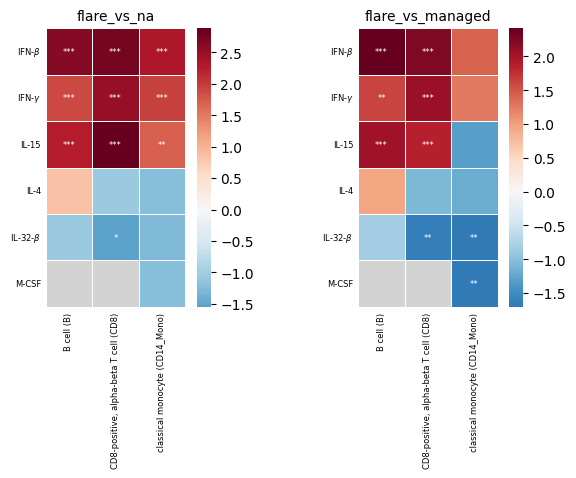

In [16]:
#### Case 1: Create heatmaps to visualize up-/down regulation of cytokines in all queried cell types AND in all contrast comparisons.

cy.plot_significant_results(
    robust_results_dict=robust_results_dict,
    results_pivot=None, 
    df_annot=None, 
    selected_celltypes=selected_celltypes_plot,
    selected_cytokines=selected_cytokines_plot,
    fontsize=6, 
    save_fig=True, 
    fig_path=""
)

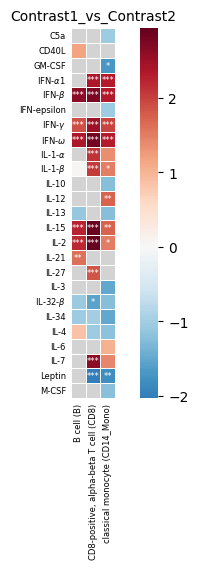

In [18]:
#### Case 2: Create heatmap to visualize up-/down regulation of cytokines in all queried cell types for one contrast comparison.

cy.plot_significant_results(
    results_pivot=robust_results_dict["flare_vs_na"][0], 
    df_annot=robust_results_dict["flare_vs_na"][1], 
    fontsize=6, 
    save_fig=False, 
    fig_path=""
)

In [ ]:
## --END-- ##